### Vérification de la disponibilité du GPU

In [10]:
import torch

# Vérifier si un GPU est disponible
if torch.cuda.is_available():
    print("GPU disponible :", torch.cuda.get_device_name(0))
    print("PyTorch utilise CUDA :", torch.cuda.is_available())
    print("Nombre de GPUs disponibles :", torch.cuda.device_count())
else:
    print("GPU non disponible. PyTorch utilise uniquement le CPU.")

# Optionnel : vérifier le périphérique actuellement utilisé
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Périphérique actif :", device)

GPU disponible : NVIDIA GeForce RTX 2060
PyTorch utilise CUDA : True
Nombre de GPUs disponibles : 1
Périphérique actif : cuda


### Verification de la disponibilité du GPU pour les calculs PyTorch :
PyTorch a été choisi pour ce projet grâce à sa compatibilité native avec CUDA, essentielle pour tirer parti du GPU RTX 2060, et sa flexibilité pour personnaliser des modèles avancés comme **DilatedNet**. Les tests avec Keras 3 en backend PyTorch ont été non concluants, révélant des limitations de performances et une gestion des données complexe. PyTorch offre une meilleure intégration des transformations dynamiques et une efficacité accrue lors de l’entraînement. Grâce à l’exportation ONNX, Franck peut continuer à utiliser Keras pour le traitement des segments, garantissant l’interopérabilité et la fluidité du pipeline. L’API pour Laura reste performante et simple à déployer, respectant les exigences du système global.
   

In [11]:
import torch
import time

# Génération de données aléatoires pour tester
data_size = 10000  # Taille des matrices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Création de deux matrices sur le GPU ou CPU selon la disponibilité
a = torch.rand(data_size, data_size, device=device)
b = torch.rand(data_size, data_size, device=device)

# Vérification que les données sont bien sur le GPU ou CPU
print(f"Device de 'a' : {a.device}")
print(f"Device de 'b' : {b.device}")

# Mesurer le temps de calcul pour une multiplication matricielle
start_time = time.time()
result = torch.mm(a, b)  # Multiplication matricielle
end_time = time.time()

print("Calcul terminé.")
print(f"Durée du calcul : {end_time - start_time:.4f} secondes.")

Device de 'a' : cuda:0
Device de 'b' : cuda:0
Calcul terminé.
Durée du calcul : 0.0264 secondes.


### Entraînement du modèle DilatedNet avec enregistrement des métriques et Data Augmentation

Cette cellule inclut :
- **Architecture :** DilatedNet, basée sur un encodeur ResNet-34 pré-entraîné.
- **Technologies utilisées :** PyTorch, CUDA (si disponible).
- **Fonctionnalités clés :**
  - Utilisation de convolutions dilatées pour extraire des informations contextuelles.
  - Décodeur avec skip connections pour reconstruire la segmentation.
  - Application de **Data Augmentation** (flips horizontaux, rotations, ajustements de luminosité/contraste).
  - Enregistrement des métriques d'entraînement et de validation à chaque époque dans un fichier CSV.


### EDA data
Il y a 2 dossiers :
- **leftImg8bit** : contient les images RGB d'origine
- **gtFine** : contient les masques de la segmentation d'images 

In [12]:
import os
import pandas as pd
from collections import defaultdict

# Chemins des dossiers
leftImg8bit_path = 'data/leftImg8bit/'
gtFine_path = 'data/gtFine/'

# Fonction pour récupérer les statistiques globales du dataset
def analyser_dataset(dossier):
    statistiques = {
        "total_images": 0,
        "total_label_ids": 0,
        "total_autres_fichiers": 0,
        "images_details": [],
        "label_ids_details": []
    }

    for root, dirs, files in os.walk(dossier):
        for file in files:
            extension = os.path.splitext(file)[1].lower()
            file_path = os.path.join(root, file)
            
            if extension == ".png" and "labelIds" in file:
                statistiques["total_label_ids"] += 1
                statistiques["label_ids_details"].append({
                    "Dossier": root,
                    "Fichier": file
                })
            elif extension == ".png":
                statistiques["total_images"] += 1
                statistiques["images_details"].append({
                    "Dossier": root,
                    "Fichier": file
                })
            else:
                statistiques["total_autres_fichiers"] += 1

    return statistiques

# Analyse des deux dossiers
statistiques_leftImg8bit = analyser_dataset(leftImg8bit_path)
statistiques_gtFine = analyser_dataset(gtFine_path)

# Construire les conclusions
conclusions = f"""
JEU DE DONNÉES
Le jeu de données est composé de 2 dossiers:
● leftImg8bit : ce dossier contient les images RGB d’origine. Ce sont les données d’entrée.
    - Nombre total d’images : {statistiques_leftImg8bit['total_images']}
● gtFine : ce dossier contient les masques de segmentation. Ce sont les données de sortie.
    - Nombre total de masques 'labelIds' : {statistiques_gtFine['total_label_ids']}
    - Nombre total d’autres fichiers : {statistiques_gtFine['total_autres_fichiers']}
Les données d’entrée sont des images de 2048 x 1024 pixels sur 3 canaux (RGB).
En ce qui concerne les données de sortie, seuls les fichiers se terminant par '_labelIds.png'
sont intéressants. Ce sont les masques correspondant aux images RGB.

Le dataset est séparé en 3 parties :
● Jeu de test : {len([d for d in statistiques_leftImg8bit['images_details'] if 'test' in d['Dossier']])} images
● Jeu d’entraînement : {len([d for d in statistiques_leftImg8bit['images_details'] if 'train' in d['Dossier']])} images
● Jeu de validation : {len([d for d in statistiques_leftImg8bit['images_details'] if 'val' in d['Dossier']])} images
"""

# Afficher les conclusions
print(conclusions)

# Exporter les détails dans des fichiers CSV pour une analyse approfondie si nécessaire
pd.DataFrame(statistiques_leftImg8bit["images_details"]).to_csv("images_leftImg8bit.csv", index=False)
pd.DataFrame(statistiques_gtFine["label_ids_details"]).to_csv("labelIds_gtFine.csv", index=False)


JEU DE DONNÉES
Le jeu de données est composé de 2 dossiers:
● leftImg8bit : ce dossier contient les images RGB d’origine. Ce sont les données d’entrée.
    - Nombre total d’images : 5000
● gtFine : ce dossier contient les masques de segmentation. Ce sont les données de sortie.
    - Nombre total de masques 'labelIds' : 4628
    - Nombre total d’autres fichiers : 4639
Les données d’entrée sont des images de 2048 x 1024 pixels sur 3 canaux (RGB).
En ce qui concerne les données de sortie, seuls les fichiers se terminant par '_labelIds.png'
sont intéressants. Ce sont les masques correspondant aux images RGB.

Le dataset est séparé en 3 parties :
● Jeu de test : 1525 images
● Jeu d’entraînement : 2975 images
● Jeu de validation : 500 images



### Exemple image RGB d'origine

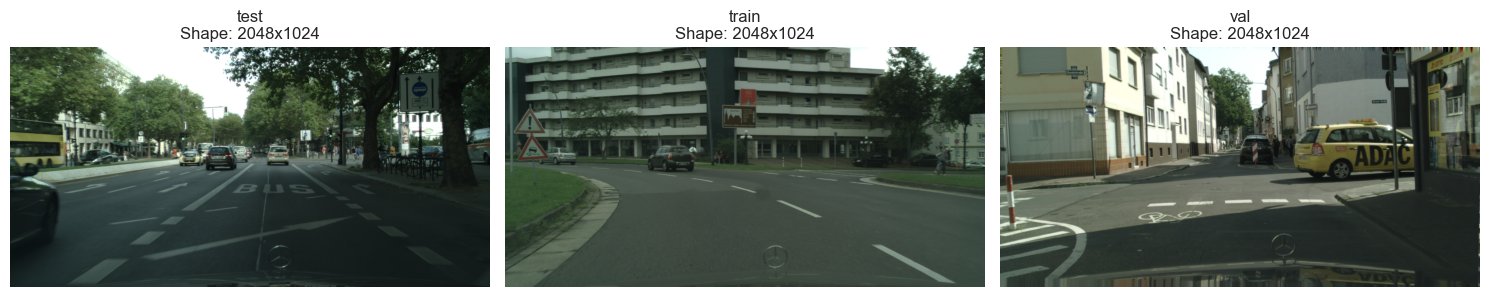

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Chemin vers le dossier leftImg8bit
leftImg8bit_path = 'data/leftImg8bit/'

# Fonction pour afficher des exemples d'images
def afficher_exemples_images(dossier_principal):
    sous_dossiers = ["test", "train", "val"]
    fig, axes = plt.subplots(1, len(sous_dossiers), figsize=(15, 5))

    for i, sous_dossier in enumerate(sous_dossiers):
        dossier = os.path.join(dossier_principal, sous_dossier)
        
        # Trouver une image dans le sous-dossier
        example_image_path = None
        for root, dirs, files in os.walk(dossier):
            for file in files:
                if file.endswith(".png"):  # Vérifier les fichiers PNG
                    example_image_path = os.path.join(root, file)
                    break
            if example_image_path:
                break
        
        if example_image_path:
            # Charger l'image et obtenir sa shape
            image = Image.open(example_image_path)
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"{sous_dossier}\nShape: {image.size[0]}x{image.size[1]}")
        else:
            axes[i].set_title(f"{sous_dossier}\nAucune image trouvée")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les exemples
afficher_exemples_images(leftImg8bit_path)


### Exemple de masque de segmentation

Associations dans test :
  - Image berlin_000000_000019_gtFine:
    - berlin_000000_000019_gtFine_color.png
    - berlin_000000_000019_gtFine_instanceIds.png
    - berlin_000000_000019_gtFine_labelIds.png
    - berlin_000000_000019_gtFine_polygons.json


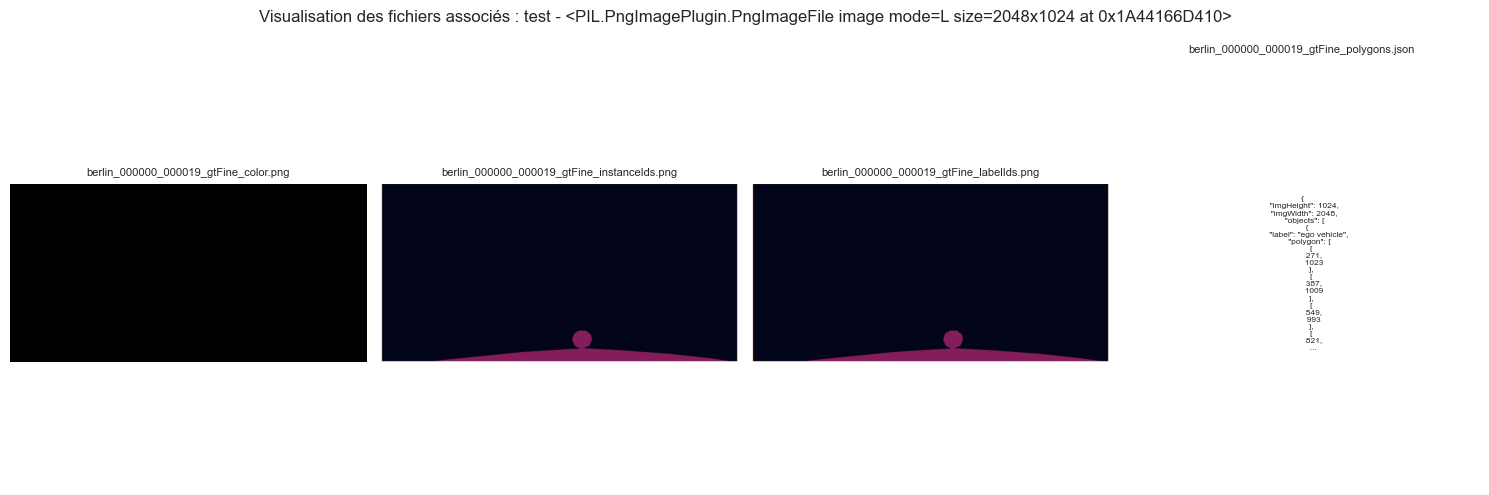

Associations dans train :
  - Image aachen_000000_000019_gtFine:
    - aachen_000000_000019_gtFine_color.png
    - aachen_000000_000019_gtFine_instanceIds.png
    - aachen_000000_000019_gtFine_labelIds.png
    - aachen_000000_000019_gtFine_polygons.json


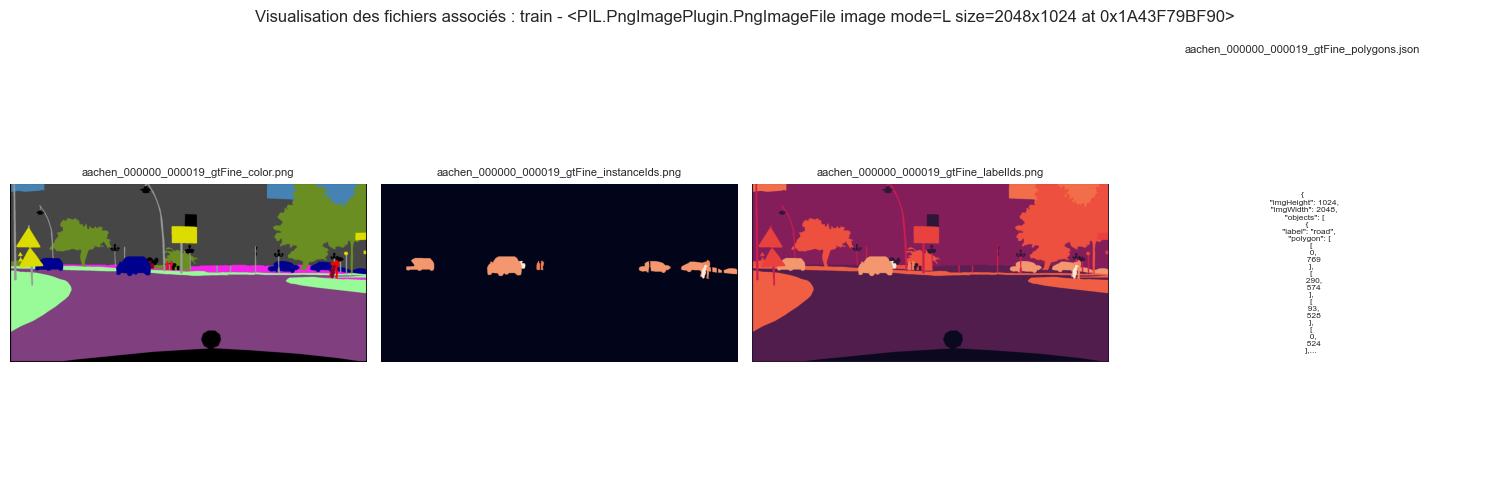

Associations dans val :
  - Image frankfurt_000000_000294_gtFine:
    - frankfurt_000000_000294_gtFine_color.png
    - frankfurt_000000_000294_gtFine_instanceIds.png
    - frankfurt_000000_000294_gtFine_labelIds.png
    - frankfurt_000000_000294_gtFine_polygons.json


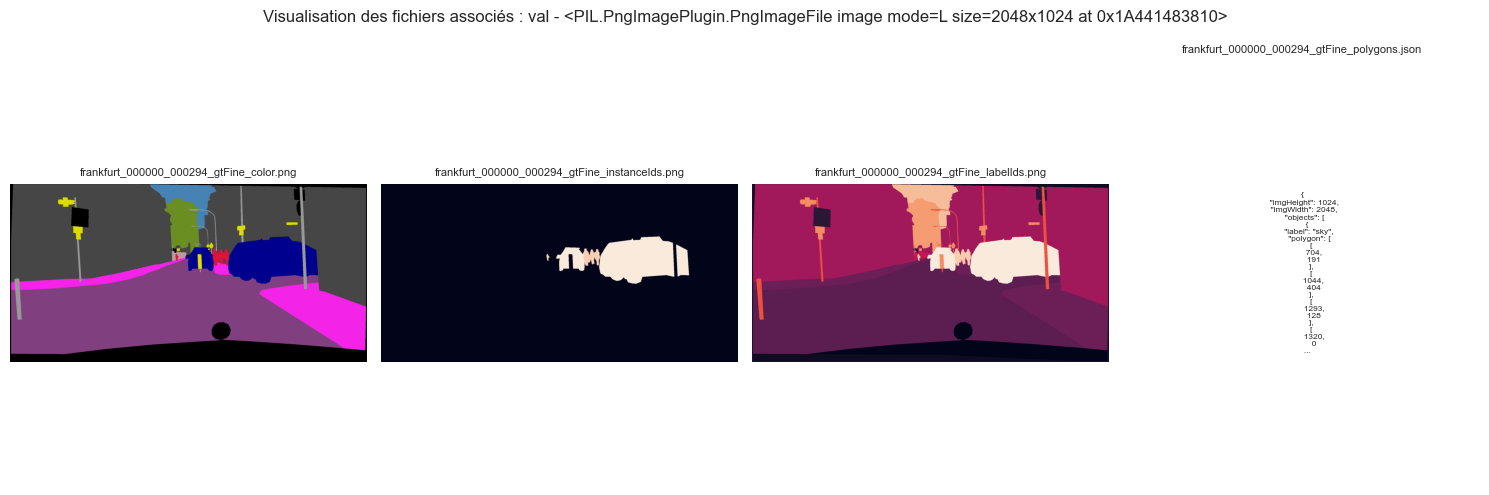

In [14]:
import os
import json
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier gtFine
gtFine_path = 'data/gtFine/'

# Fonction pour analyser les fichiers par image
def analyser_fichiers_et_associations(dossier_principal):
    statistiques = {}

    for sous_dossier in ["test", "train", "val"]:
        chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
        fichiers_par_image = defaultdict(list)
        types_de_fichiers = defaultdict(int)

        # Parcourir les fichiers du sous-dossier
        for root, dirs, files in os.walk(chemin_sous_dossier):
            for file in files:
                extension = os.path.splitext(file)[1].lower()
                base_name = "_".join(file.split("_")[:-1])  # Identifier le groupe d'une image (numérotation)
                fichiers_par_image[base_name].append(os.path.join(root, file))
                types_de_fichiers[extension] += 1

        statistiques[sous_dossier] = {
            "types_de_fichiers": dict(types_de_fichiers),
            "fichiers_par_image": dict(fichiers_par_image)
        }

    return statistiques

# Fonction pour afficher et visualiser les fichiers associés
def afficher_exemples_et_visualisations(statistiques):
    for sous_dossier, data in statistiques.items():
        fichiers_par_image = data["fichiers_par_image"]

        print(f"Associations dans {sous_dossier} :")
        
        # Limité à 1 image pour visualisation complète dans chaque sous-dossier
        for image, fichiers in list(fichiers_par_image.items())[:1]:
            print(f"  - Image {image}:")
            for fichier in fichiers:
                print(f"    - {os.path.basename(fichier)}")

            # Visualiser les fichiers associés
            fig, axes = plt.subplots(1, len(fichiers), figsize=(15, 5))
            for idx, fichier in enumerate(fichiers):
                if fichier.endswith(".png"):  # Afficher les images PNG
                    image = Image.open(fichier)
                    axes[idx].imshow(image)
                    axes[idx].axis("off")
                    axes[idx].set_title(os.path.basename(fichier), fontsize=8)
                elif fichier.endswith(".json"):  # Lire et afficher un extrait du JSON
                    with open(fichier, 'r') as f:
                        json_content = json.load(f)
                        extrait = json.dumps(json_content, indent=2)[:300] + "..."
                    axes[idx].text(0.5, 0.5, extrait, fontsize=6, wrap=True, ha='center', va='center')
                    axes[idx].axis("off")
                    axes[idx].set_title(os.path.basename(fichier), fontsize=8)
                else:
                    axes[idx].axis("off")
                    axes[idx].set_title(f"{os.path.basename(fichier)}\n(non visualisable)", fontsize=8)

            plt.suptitle(f"Visualisation des fichiers associés : {sous_dossier} - {image}")
            plt.tight_layout()
            plt.show()

# Analyser les fichiers et visualiser
statistiques_gtFine = analyser_fichiers_et_associations(gtFine_path)
afficher_exemples_et_visualisations(statistiques_gtFine)

### Analyse des données et utilisation des fichiers

#### Données d'entrée : `leftImg8bit_path`
- Les données d’entrée sont situées dans le dossier `leftImg8bit`.
- Ce dossier contient les **images RGB originales**, qui sont les données d’entrée pour l’entraînement du modèle.
- **Caractéristiques des images d’entrée** :
  - Résolution : **2048 x 1024 pixels**.
  - Canaux : **3 canaux (RGB)**.
- Ces images représentent l'environnement que le modèle doit analyser et segmenter.

---

### Données de sortie : `gtFine_path`
- Les données de sortie sont situées dans le dossier `gtFine`.
- Ce dossier contient plusieurs types de fichiers, mais nous nous intéressons uniquement aux fichiers dont le nom se termine par `*_labelIds.png`.

#### Fichiers `*_labelIds.png` :
- Ce sont les **masques d'annotation** pour la segmentation.
- Chaque pixel du masque a une valeur correspondant à l'**identifiant d'une classe** (par exemple, route, voiture, trottoir, etc.).
- **Caractéristiques des fichiers `*_labelIds.png`** :
  - Les valeurs des pixels indiquent les identifiants des labels de segmentation.
  - Il existe **32 catégories différentes** à mapper vers **8 catégories principales** pour simplifier le problème.

#### Autres fichiers dans `gtFine` :
Bien que nous ne les utilisions pas dans ce cas précis, voici les autres types de fichiers présents :
- **`*_polygons.json`** :
  - Contiennent des métadonnées descriptives pour chaque objet (par exemple, catégories et polygones de segmentation).
- **`*_color.png`** :
  - Représentations visuelles des masques, où chaque classe est représentée par une couleur unique.
- **`*_instanceIds.png`** :
  - Identifiants uniques pour chaque instance d'objet dans les images (utile pour la segmentation d'instances).

---

### Structure du dataset

- Le dataset est séparé en **3 parties** :
  1. **Jeu de test** : **1525 images**.
  2. **Jeu d’entraînement** : **2975 images**.
  3. **Jeu de validation** : **500 images**.

Chaque partie est organisée de la manière suivante :
- Les images d’entrée sont situées dans le dossier `leftImg8bit/test`, `leftImg8bit/train`, ou `leftImg8bit/val`.
- Les masques d’annotation (données de sortie) sont situés dans `gtFine/test`, `gtFine/train`, ou `gtFine/val`.

---

## Résumé

| Type de données          | Chemin                | Description                                                                            |
|--------------------------|-----------------------|----------------------------------------------------------------------------------------|
| **Images d’entrée**      | `leftImg8bit_path`   | Images RGB (2048 x 1024, 3 canaux).                                                   |
| **Masques d’annotation** | `gtFine_path`        | Fichiers `*_labelIds.png` : identifiants des labels pour chaque pixel.                |
| **Jeu de test**          | `test`              | Contient 1525 images et leurs masques associés.                                       |
| **Jeu d’entraînement**   | `train`             | Contient 2975 images et leurs masques associés.                                       |
| **Jeu de validation**    | `val`               | Contient 500 images et leurs masques associés.                                        |

---

### Utilisation pour l'entraînement

- **Données d’entrée** : Les images RGB du dossier `leftImg8bit`.
- **Données de sortie** : Les masques `*_labelIds.png` du dossier `gtFine`.

Ces deux ensembles de données permettront d'entraîner un modèle de segmentation capable d'identifier et de classer chaque pixel dans l'image en fonction des 8 catégories principales définies.



### Fichiers dans le train

In [15]:
import os

train_path = 'data/gtFine/train/'
print("Fichiers disponibles dans le dossier train :")
print(os.listdir(train_path))


Fichiers disponibles dans le dossier train :
['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


### Exemple de masque de segmentation et de comment fonctionne la segmentation par pixel

Shape du masque : (1024, 2048)
Valeurs uniques dans le masque : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]
Portion du masque (200x250) :
 [[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


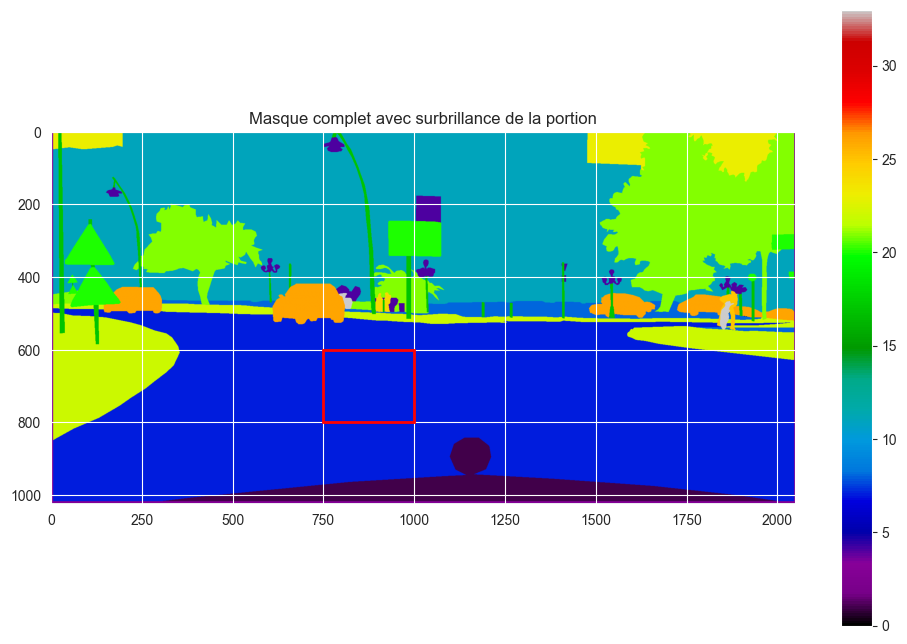

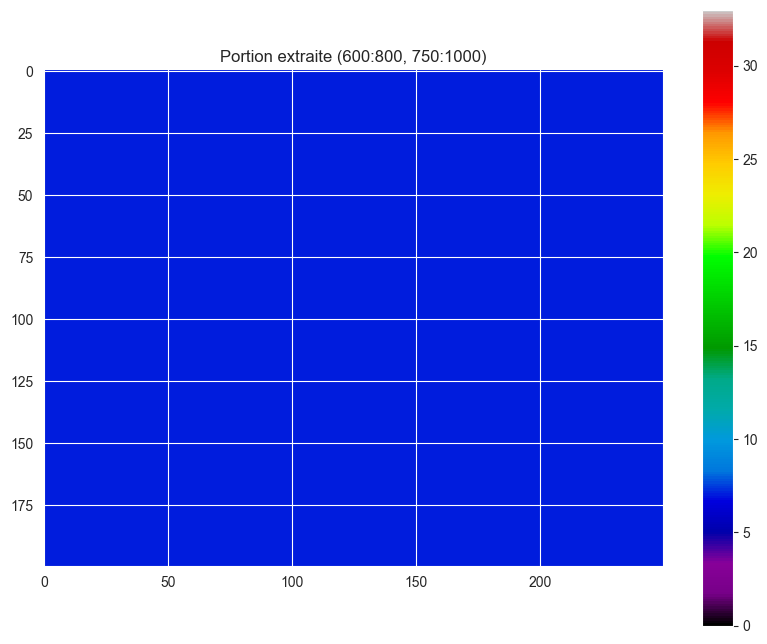

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemin vers le dossier gtFine
gtFine_path = 'data/gtFine/'  # Dossier principal
image_subfolder = 'train/aachen'  # Sous-dossier
image_name = 'aachen_000000_000019_gtFine_labelIds.png'  # Nom exact de l'image

# Construire le chemin complet vers l'image
image_path = f"{gtFine_path}{image_subfolder}/{image_name}"

# Charger l'image
mask = np.array(Image.open(image_path))  # Convertir l'image en une matrice numpy

# Afficher la taille de l'image
print("Shape du masque :", mask.shape)

# Afficher les valeurs uniques dans le masque (identifiants des classes présentes)
print("Valeurs uniques dans le masque :", np.unique(mask))

# Définir la portion du masque à visualiser
start_row, end_row = 600, 800  # Ordonnées sélectionnées
start_col, end_col = 750, 1000  # Abscisses sélectionnées
portion = mask[start_row:end_row, start_col:end_col]

# Afficher la portion extraite
print(f"Portion du masque ({end_row-start_row}x{end_col-start_col}) :\n", portion)

# Définir les limites de la palette (valeurs minimales et maximales de l'image complète)
vmin, vmax = mask.min(), mask.max()

# Visualiser le masque complet avec surbrillance de la portion
plt.figure(figsize=(12, 8))
plt.imshow(mask, cmap="nipy_spectral", vmin=vmin, vmax=vmax)  # Applique une palette fixe
plt.colorbar()
plt.title("Masque complet avec surbrillance de la portion")

# Ajouter un rectangle pour la portion sélectionnée
plt.gca().add_patch(plt.Rectangle((start_col, start_row), end_col-start_col, end_row-start_row, 
                                   edgecolor='red', facecolor='none', lw=2))  # Rectangle rouge
plt.show()

# Visualiser uniquement la portion extraite avec la même palette
plt.figure(figsize=(10, 8))
plt.imshow(portion, cmap="nipy_spectral", vmin=vmin, vmax=vmax)  # Applique la même échelle que l'image complète
plt.colorbar()
plt.title(f"Portion extraite ({start_row}:{end_row}, {start_col}:{end_col})")
plt.show()


#### Observations

#### Shape du masque
- La résolution de l'image est **(1024, 2048)**.
- Chaque pixel du masque correspond à une valeur unique représentant une **classe d'objets** dans l'image.

---

#### Valeurs uniques dans le masque
- Les valeurs uniques dans le masque correspondent aux **identifiants des classes** de segmentation.
- Ces valeurs permettent d'assigner une catégorie à chaque pixel, comme "route", "ciel", "bâtiment", etc.

Dans cette image, les valeurs observées sont :
- `7` : **Route** (Classe `Road`).
- `21` : **Végétation** (Classe `Vegetation`).
- `23` : **Ciel** (Classe `Sky`).
- `3` : **Mur/Bâtiment** (Classe `Building/Wall`).

---

#### Interprétation visuelle
L'image ci-dessus affiche le masque à l'aide d'une palette de couleurs distinctes. Voici les principales observations :

1. **Masque complet :**
   - La portion encadrée en **rouge** correspond à une zone où la route est bien visible.
   - Les zones environnantes incluent de la **végétation**, du **ciel**, et d'autres objets.

2. **Portion extraite :**
   - La portion (délimitée par les coordonnées 600:800 en ordonnée et 750:1000 en abscisse) contient exclusivement la classe **Route**.
   - Cela se reflète par la valeur `7` sur tous les pixels de la portion extraite.

---

#### Comparaison entre masque complet et portion extraite
- Dans le **masque complet**, la palette de couleurs permet de distinguer toutes les classes (par exemple, ciel, végétation, route).
- Dans la **portion extraite**, la valeur `7` est prédominante, correspondant uniquement à la classe "Route".
- La cohérence des couleurs entre le masque complet et la portion est assurée grâce à une échelle fixe (`vmin` et `vmax`).

#### **Correspondance des classes de segmentation**
- Ces informations sont tirées de la documentation officielle de Cityscapes. Les identifiants sont utilisés dans les fichiers `*_labelIds.png` pour représenter les classes de segmentation.

| **Classe (EN)**       | **Classe (FR)**       | **ID** | **TrainID** | **Catégorie**     | **CatID** | **HasInstances** | **IgnoreInEval** | **Couleur (RGB)** | **Couleur (description)**      |
|------------------------|-----------------------|--------|-------------|-------------------|-----------|------------------|------------------|-------------------|--------------------------------|
| unlabeled             | Non étiqueté         | 0      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| ego vehicle           | Véhicule propre      | 1      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| rectification border  | Bord rectifié        | 2      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| out of roi            | Hors région d'intérêt| 3      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| static                | Statique            | 4      | 255         | void              | 0         | False            | True             | (0, 0, 0)         | Noir                           |
| dynamic               | Dynamique           | 5      | 255         | void              | 0         | False            | True             | (111, 74, 0)      | Marron foncé                   |
| ground                | Sol                 | 6      | 255         | void              | 0         | False            | True             | (81, 0, 81)       | Violet foncé                   |
| road                  | Route               | 7      | 0           | flat              | 1         | False            | False            | (128, 64, 128)    | Violet                         |
| sidewalk              | Trottoir            | 8      | 1           | flat              | 1         | False            | False            | (244, 35, 232)    | Rose                           |
| parking               | Parking             | 9      | 255         | flat              | 1         | False            | True             | (250, 170, 160)   | Rose pâle                      |
| rail track            | Rail                | 10     | 255         | flat              | 1         | False            | True             | (230, 150, 140)   | Rouge clair                    |
| building              | Bâtiment            | 11     | 2           | construction      | 2         | False            | False            | (70, 70, 70)      | Gris                           |
| wall                  | Mur                 | 12     | 3           | construction      | 2         | False            | False            | (102, 102, 156)   | Gris-bleu                      |
| fence                 | Clôture             | 13     | 4           | construction      | 2         | False            | False            | (190, 153, 153)   | Gris clair                     |
| guard rail            | Garde-corps         | 14     | 255         | construction      | 2         | False            | True             | (180, 165, 180)   | Mauve                          |
| bridge                | Pont                | 15     | 255         | construction      | 2         | False            | True             | (150, 100, 100)   | Marron                         |
| tunnel                | Tunnel              | 16     | 255         | construction      | 2         | False            | True             | (150, 120, 90)    | Beige                          |
| pole                  | Poteau              | 17     | 5           | object            | 3         | False            | False            | (153, 153, 153)   | Gris clair                     |
| polegroup             | Groupe de poteaux   | 18     | 255         | object            | 3         | False            | True             | (153, 153, 153)   | Gris clair                     |
| traffic light         | Feu de signalisation| 19     | 6           | object            | 3         | False            | False            | (250, 170, 30)    | Orange                         |
| traffic sign          | Panneau de signal.  | 20     | 7           | object            | 3         | False            | False            | (220, 220, 0)     | Jaune                          |
| vegetation            | Végétation          | 21     | 8           | nature            | 4         | False            | False            | (107, 142, 35)    | Vert foncé                     |
| terrain               | Terrain             | 22     | 9           | nature            | 4         | False            | False            | (152, 251, 152)   | Vert clair                     |
| sky                   | Ciel                | 23     | 10          | sky               | 5         | False            | False            | (70, 130, 180)    | Bleu ciel                      |
| person                | Personne            | 24     | 11          | human             | 6         | True             | False            | (220, 20, 60)     | Rouge                          |
| rider                 | Cycliste/Motard     | 25     | 12          | human             | 6         | True             | False            | (255, 0, 0)       | Rouge vif                      |
| car                   | Voiture             | 26     | 13          | vehicle           | 7         | True             | False            | (0, 0, 142)       | Bleu foncé                     |
| truck                 | Camion              | 27     | 14          | vehicle           | 7         | True             | False            | (0, 0, 70)        | Bleu très foncé                |
| bus                   | Bus                 | 28     | 15          | vehicle           | 7         | True             | False            | (0, 60, 100)      | Bleu-vert foncé                |
| caravan               | Caravane            | 29     | 255         | vehicle           | 7         | True             | True             | (0, 0, 90)        | Bleu nuit                      |
| trailer               | Remorque            | 30     | 255         | vehicle           | 7         | True             | True             | (0, 0, 110)       | Bleu acier                     |
| train                 | Train               | 31     | 16          | vehicle           | 7         | True             | False            | (0, 80, 100)      | Turquoise foncé                |
| motorcycle            | Moto                | 32     | 17          | vehicle           | 7         | True             | False            | (0, 0, 230)       | Bleu vif                       |
| bicycle               | Vélo                | 33     | 18          | vehicle           | 7         | True             | False            | (119, 11, 32)     | Rouge sombre                   |
| license plate         | Plaque d'immatric. | -1     | -1          | vehicle           | 7         | False            | True             | (0, 0, 142)       | Bleu foncé                     |

---

#### **Regroupement en 8 catégories principales**

```python
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

### Entraînement du modèle DilatedNet avec enregistrement des métriques et Data Augmentation

Cette cellule inclut :
- **Architecture :** DilatedNet, basée sur un encodeur ResNet-34 pré-entraîné.
- **Technologies utilisées :** PyTorch, CUDA (si disponible).
- **Fonctionnalités clés :**
  - Utilisation de convolutions dilatées pour extraire des informations contextuelles.
  - Décodeur avec skip connections pour reconstruire la segmentation.
  - Application de **Data Augmentation** (flips horizontaux, rotations, ajustements de luminosité/contraste).
  - Enregistrement des métriques d'entraînement et de validation à chaque époque dans un fichier CSV.

In [9]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torchvision.transforms import functional as TF

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définition des chemins
base_dir = os.path.join(os.getcwd(), 'data')
train_image_dir = os.path.join(base_dir, 'leftImg8bit', 'train')
train_mask_dir = os.path.join(base_dir, 'gtFine', 'train')
val_image_dir = os.path.join(base_dir, 'leftImg8bit', 'val')
val_mask_dir = os.path.join(base_dir, 'gtFine', 'val')

model_save_path = os.path.join(os.getcwd(), "models", "segmentation_model.pth")
metrics_file_path = os.path.join(base_dir, "metrics.csv")

# Mapping des catégories
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}
category_mapping = {subclass: idx for idx, (cat, subclasses) in enumerate(cats.items()) for subclass in subclasses}

# Transformations et augmentations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


class Augmentations:
    def __call__(self, image, mask):
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        angle = torch.randint(-10, 10, (1,)).item()
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        color_jitter = transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2)
        image = color_jitter(image)
        return image, mask


class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None, augmentations = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.augmentations = augmentations
        self.images = []
        self.masks = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png"):
                    image_path = os.path.join(root, file)
                    mask_path = os.path.join(mask_dir, root.split(os.sep)[-1],
                                             file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))
                    if os.path.exists(mask_path):
                        self.images.append(image_path)
                        self.masks.append(mask_path)

        print(f"Nombre d'images trouvées : {len(self.images)}")
        print(f"Nombre de masques trouvés : {len(self.masks)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        if self.transform:
            image = self.transform(image)
            mask = mask.resize((256, 256))
            mask = np.array(mask)
            mapped_mask = np.zeros_like(mask, dtype = np.long)
            for val, cat_idx in category_mapping.items():
                mapped_mask[mask == val] = cat_idx
            mask = torch.tensor(mapped_mask, dtype = torch.long)
        return image, mask


augmentations = Augmentations()
train_dataset = CityscapesDataset(
    image_dir = train_image_dir,
    mask_dir = train_mask_dir,
    transform = transform,
    augmentations = augmentations
)
val_dataset = CityscapesDataset(
    image_dir = val_image_dir,
    mask_dir = val_mask_dir,
    transform = transform,
    augmentations = None
)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = False)


class DilatedNet(nn.Module):
    def __init__(self, num_classes):
        super(DilatedNet, self).__init__()
        self.encoder = models.resnet34(weights = 'IMAGENET1K_V1')
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.enc1 = nn.Sequential(*self.encoder_layers[:3])
        self.enc2 = nn.Sequential(*self.encoder_layers[3:5])
        self.enc3 = nn.Sequential(*self.encoder_layers[5])
        self.enc4 = nn.Sequential(*self.encoder_layers[6])
        self.enc5 = nn.Sequential(*self.encoder_layers[7])
        self.dilated1 = nn.Conv2d(512, 256, kernel_size = 3, dilation = 2, padding = 2)
        self.dilated2 = nn.Conv2d(256, 256, kernel_size = 3, dilation = 4, padding = 4)
        self.dec4 = self._decoder_block(256 + 256, 128)
        self.dec3 = self._decoder_block(128 + 128, 64)
        self.dec2 = self._decoder_block(64 + 64, 64)
        self.dec1 = self._decoder_block(64, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size = 1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        dilated = self.dilated1(enc5)
        dilated = self.dilated2(dilated)
        enc4_resized = F.interpolate(enc4, size = dilated.shape[2:], mode = "bilinear", align_corners = False)
        dec4 = self.dec4(torch.cat([dilated, enc4_resized], dim = 1))
        enc3_resized = F.interpolate(enc3, size = dec4.shape[2:], mode = "bilinear", align_corners = False)
        dec3 = self.dec3(torch.cat([dec4, enc3_resized], dim = 1))
        enc2_resized = F.interpolate(enc2, size = dec3.shape[2:], mode = "bilinear", align_corners = False)
        dec2 = self.dec2(torch.cat([dec3, enc2_resized], dim = 1))
        enc1_resized = F.interpolate(enc1, size = dec2.shape[2:], mode = "bilinear", align_corners = False)
        dec1 = self.dec1(enc1_resized)
        final_output = self.final(dec1)
        final_output_resized = F.interpolate(final_output, size = (256, 256), mode = "bilinear", align_corners = False)
        return final_output_resized


def train_model_with_early_stopping(model, dataloaders, optimizer, criterion, num_epochs, patience, metrics_file):
    model = model.to(device)
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0
    metrics_df = pd.DataFrame(columns = ["epoch", "train_loss", "val_loss"])

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(dataloaders["train"]):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(dataloaders["train"])

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in dataloaders["val"]:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        val_loss /= len(dataloaders["val"])

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        new_row = pd.DataFrame({
            "epoch": [epoch + 1],
            "train_loss": [train_loss],
            "val_loss": [val_loss]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index = True)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
            print("Validation loss improved, saving the model...")
            torch.save(best_model_weights, model_save_path)
        else:
            patience_counter += 1
            print(f"Early stopping patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    metrics_df.to_csv(metrics_file, index = False)
    print(f"Métriques sauvegardées dans {metrics_file}")

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    return model


num_classes = 8
model = DilatedNet(num_classes = num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

dataloaders = {"train": train_loader, "val": val_loader}

num_epochs = 8
patience = 3

model = train_model_with_early_stopping(
    model,
    dataloaders,
    optimizer,
    criterion,
    num_epochs = num_epochs,
    patience = patience,
    metrics_file = metrics_file_path
)

print(f"Model saved at {model_save_path}")


Using device: cuda
Nombre d'images trouvées : 2975
Nombre de masques trouvés : 2975
Nombre d'images trouvées : 500
Nombre de masques trouvés : 500
Epoch 1/8


100%|██████████| 186/186 [06:52<00:00,  2.22s/it]
C:\Users\pat\AppData\Local\Temp\ipykernel_5536\3900151221.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index = True)


Train Loss: 1.1768, Val Loss: 0.9880
Validation loss improved, saving the model...
Epoch 2/8


100%|██████████| 186/186 [07:03<00:00,  2.27s/it]


Train Loss: 0.9500, Val Loss: 0.9362
Validation loss improved, saving the model...
Epoch 3/8


100%|██████████| 186/186 [06:50<00:00,  2.21s/it]


Train Loss: 0.8885, Val Loss: 0.9235
Validation loss improved, saving the model...
Epoch 4/8


100%|██████████| 186/186 [06:49<00:00,  2.20s/it]


Train Loss: 0.8530, Val Loss: 0.9013
Validation loss improved, saving the model...
Epoch 5/8


100%|██████████| 186/186 [07:04<00:00,  2.28s/it]


Train Loss: 0.8335, Val Loss: 0.8847
Validation loss improved, saving the model...
Epoch 6/8


100%|██████████| 186/186 [07:44<00:00,  2.50s/it]


Train Loss: 0.8253, Val Loss: 0.8545
Validation loss improved, saving the model...
Epoch 7/8


100%|██████████| 186/186 [08:33<00:00,  2.76s/it]


Train Loss: 0.8153, Val Loss: 0.8505
Validation loss improved, saving the model...
Epoch 8/8


100%|██████████| 186/186 [07:08<00:00,  2.30s/it]


Train Loss: 0.8068, Val Loss: 0.8350
Validation loss improved, saving the model...
Métriques sauvegardées dans D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\data\metrics.csv
Model saved at D:\OC_IA\P8\OC_IA_P8_VoitureAutonome\models\segmentation_model.pth
